## Forecasting with Machine Learning

There are two things to establish before designing a forecasting model:
- what information is available at the time a forecast is made(features), and
- the time period during which you require forecasted values(target)

**Forecast Horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast.

## Prepraing Data for Forecasting

In [2]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index = pd.period_range(start="2010", freq="A", periods = N, name="Year"),
    dtype = pd.Int8Dtype,
)
ts

Year
2010     0
2011     1
2012     2
2013     3
2014     4
2015     5
2016     6
2017     7
2018     8
2019     9
2020    10
2021    11
2022    12
2023    13
2024    14
2025    15
2026    16
2027    17
2028    18
2029    19
Freq: A-DEC, dtype: object

In [3]:
# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

In [6]:
display(X.head())
display(y.tail())

,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
Year,,,,,
2010,None,None,None,None,None
2011,None,None,None,None,None
2012,0,None,None,None,None
2013,1,0,None,None,None
2014,2,1,0,None,None


,y_step_3,y_step_2,y_step_1
Year,,,
2025,17,16,15
2026,18,17,16
2027,19,18,17
2028,None,19,18
2029,None,None,19


In [12]:
data = pd.concat({"Targets" : y, "Features" : X}, axis = 1)
data.head().style.set_properties(['Targets'], **{'background-color': 'black'}) \
                   .set_properties(['Features'], **{'background-color': 'gray'})

In [11]:
data.tail()

Targets                   Features                                
     y_step_3 y_step_2 y_step_1  y_lag_2 y_lag_3 y_lag_4 y_lag_5 y_lag_6
Year                                                                    
2025       17       16       15       13      12      11      10       9
2026       18       17       16       14      13      12      11      10
2027       19       18       17       15      14      13      12      11
2028     None       19       18       16      15      14      13      12
2029     None     None       19       17      16      15      14      13

## Multistep Forecasting Strategies

There are number of strategies for producing the multiple target steps required for a forecast.

1. **Multioutput model**: Linear regression and neural newtorks can both produce multiple outputs. XGBoost can't do this.

2. **Direct Strategy** : Train separate model for each step in the horizon: one model forecast 1-step ahead, another 2-step ahead, and so on. **Disadvantage : Computationally expensive**

3. **Recursive Strategy** : Train a single step model and use its forecast to update the lag features for the next step. **Disadvantage: since errors will propagate from one step to another step, forecasts can be inaccurate for long horizons.**

4. **DiRec Strategy** : Combinatin of direct and recursive strategy.

## Example - Flu Trends

In [13]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [14]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [16]:
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Time Series Upskilling/Times series kaggle/data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace = True
)
flu_trends.drop("Week", axis = 1, inplace = True)

In [17]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


In [27]:
def make_lags(ts, lags, lead_time = 1):
  return pd.concat(
      {
        f'y_lag_{i}': ts.shift(i)
        for i in range(lead_time, lags + lead_time)
      },
      axis = 1)

In [28]:
# four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [29]:
def make_multistep_target(ts, steps):
  return pd.concat(
      {
          f'y_step_{i + 1}' : ts.shift(-i)
          for i in range(steps)
      },
      axis = 1
  )

y = make_multistep_target(y, steps=8).dropna()

y, X = y.align(X, join="inner", axis = 0)
display(X.head())
display(y.head())

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0


#### Multi output model :  LInear Regression

In [30]:
# create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index = X_train.index, columns = y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index = X_test.index, columns = y.columns)

Train RMSE: 389.12
Test RMSE: 582.33


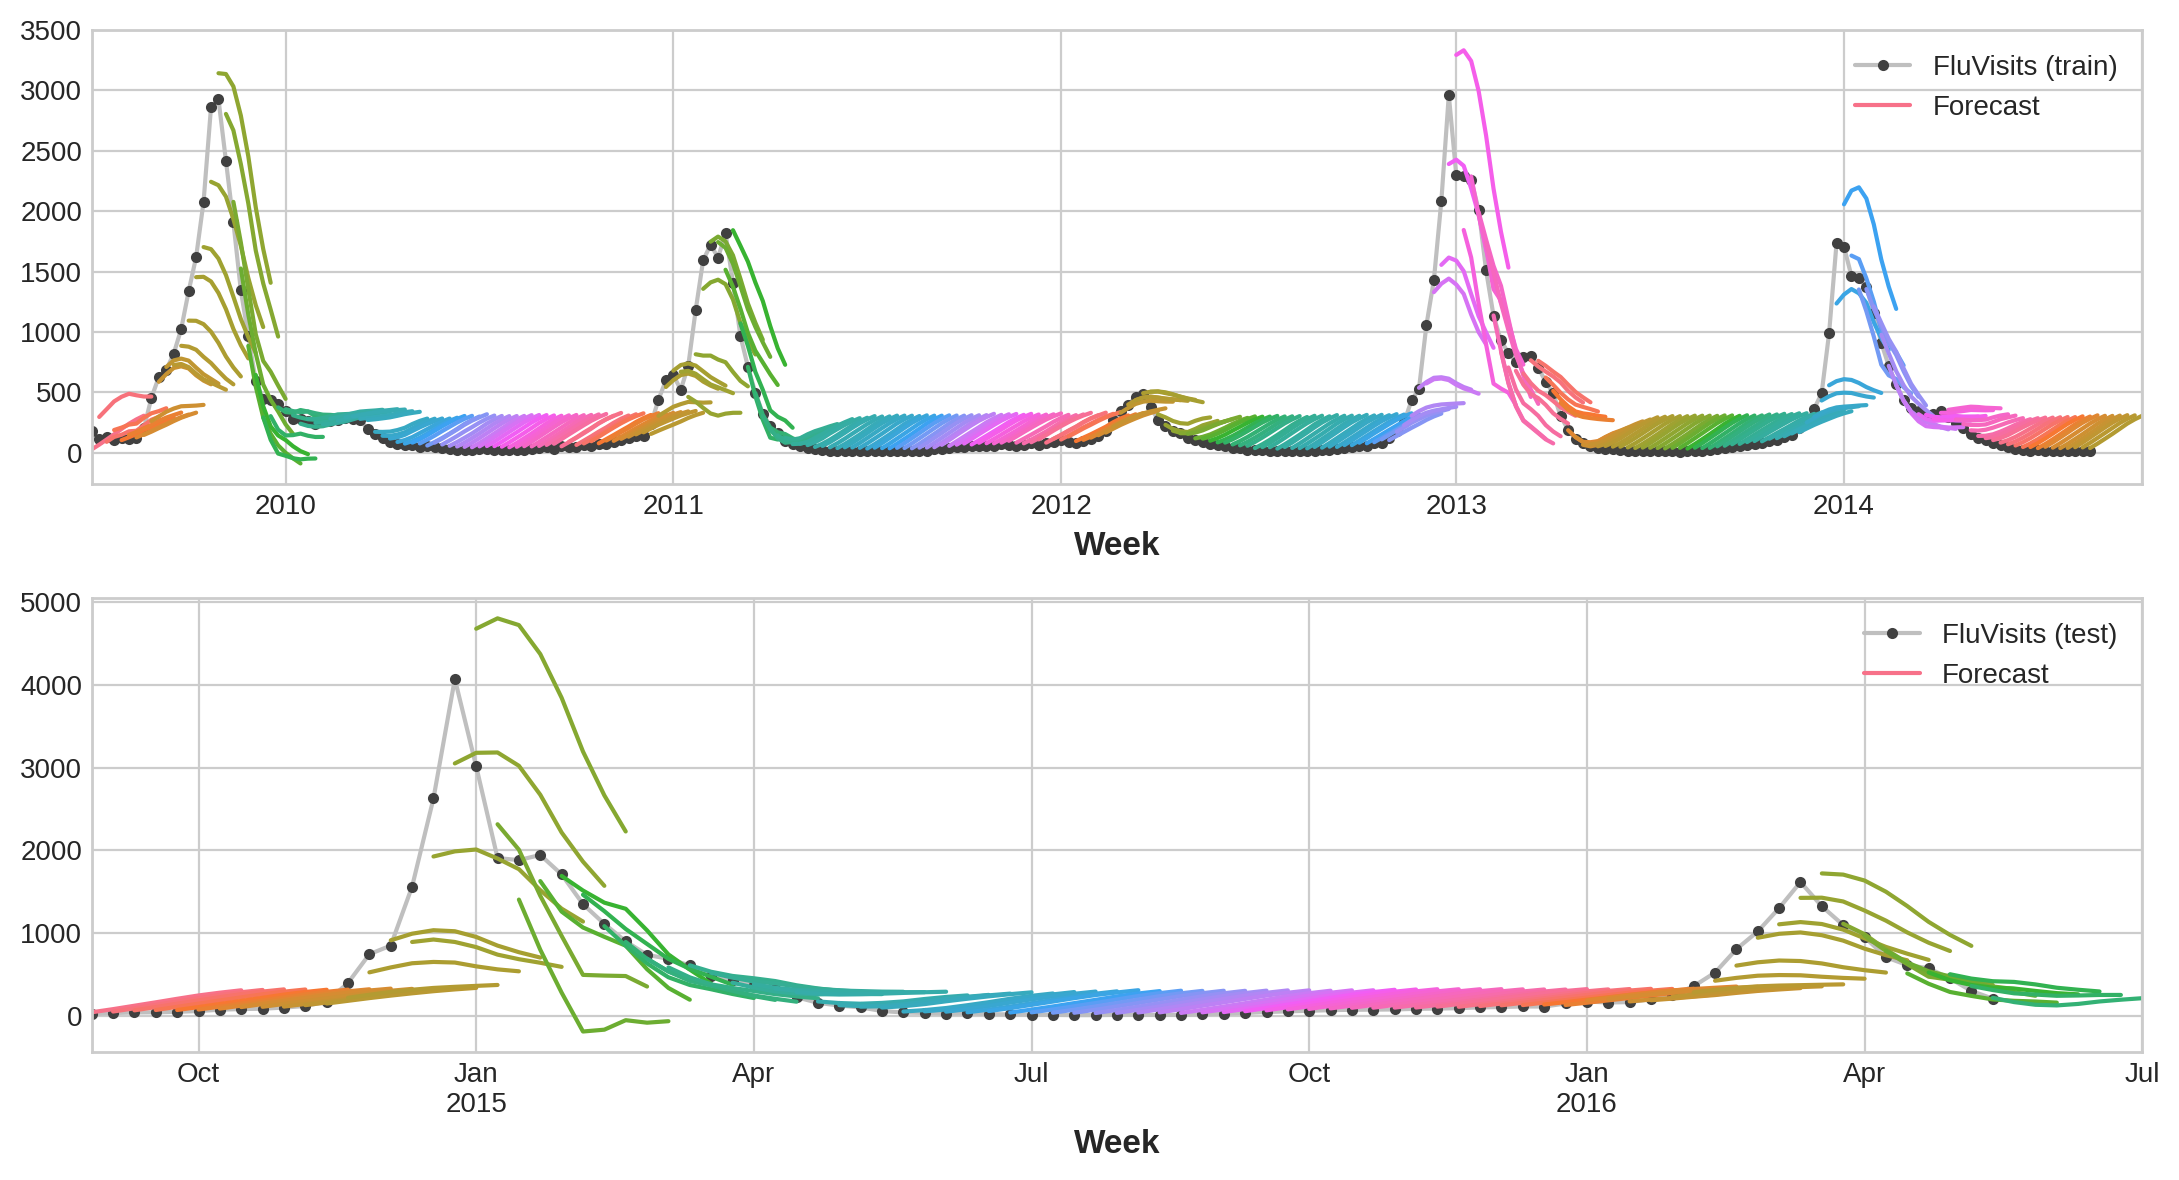

In [32]:
train_rmse = mean_squared_error(y_train, y_fit, squared = False)
test_rmse = mean_squared_error(y_test, y_pred, squared = False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct Starategy : XGBoost

In [33]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index = X_train.index, columns = y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index = X_test.index, columns = y.columns)

Train RMSE: 1.19
Test RMSE: 494.52


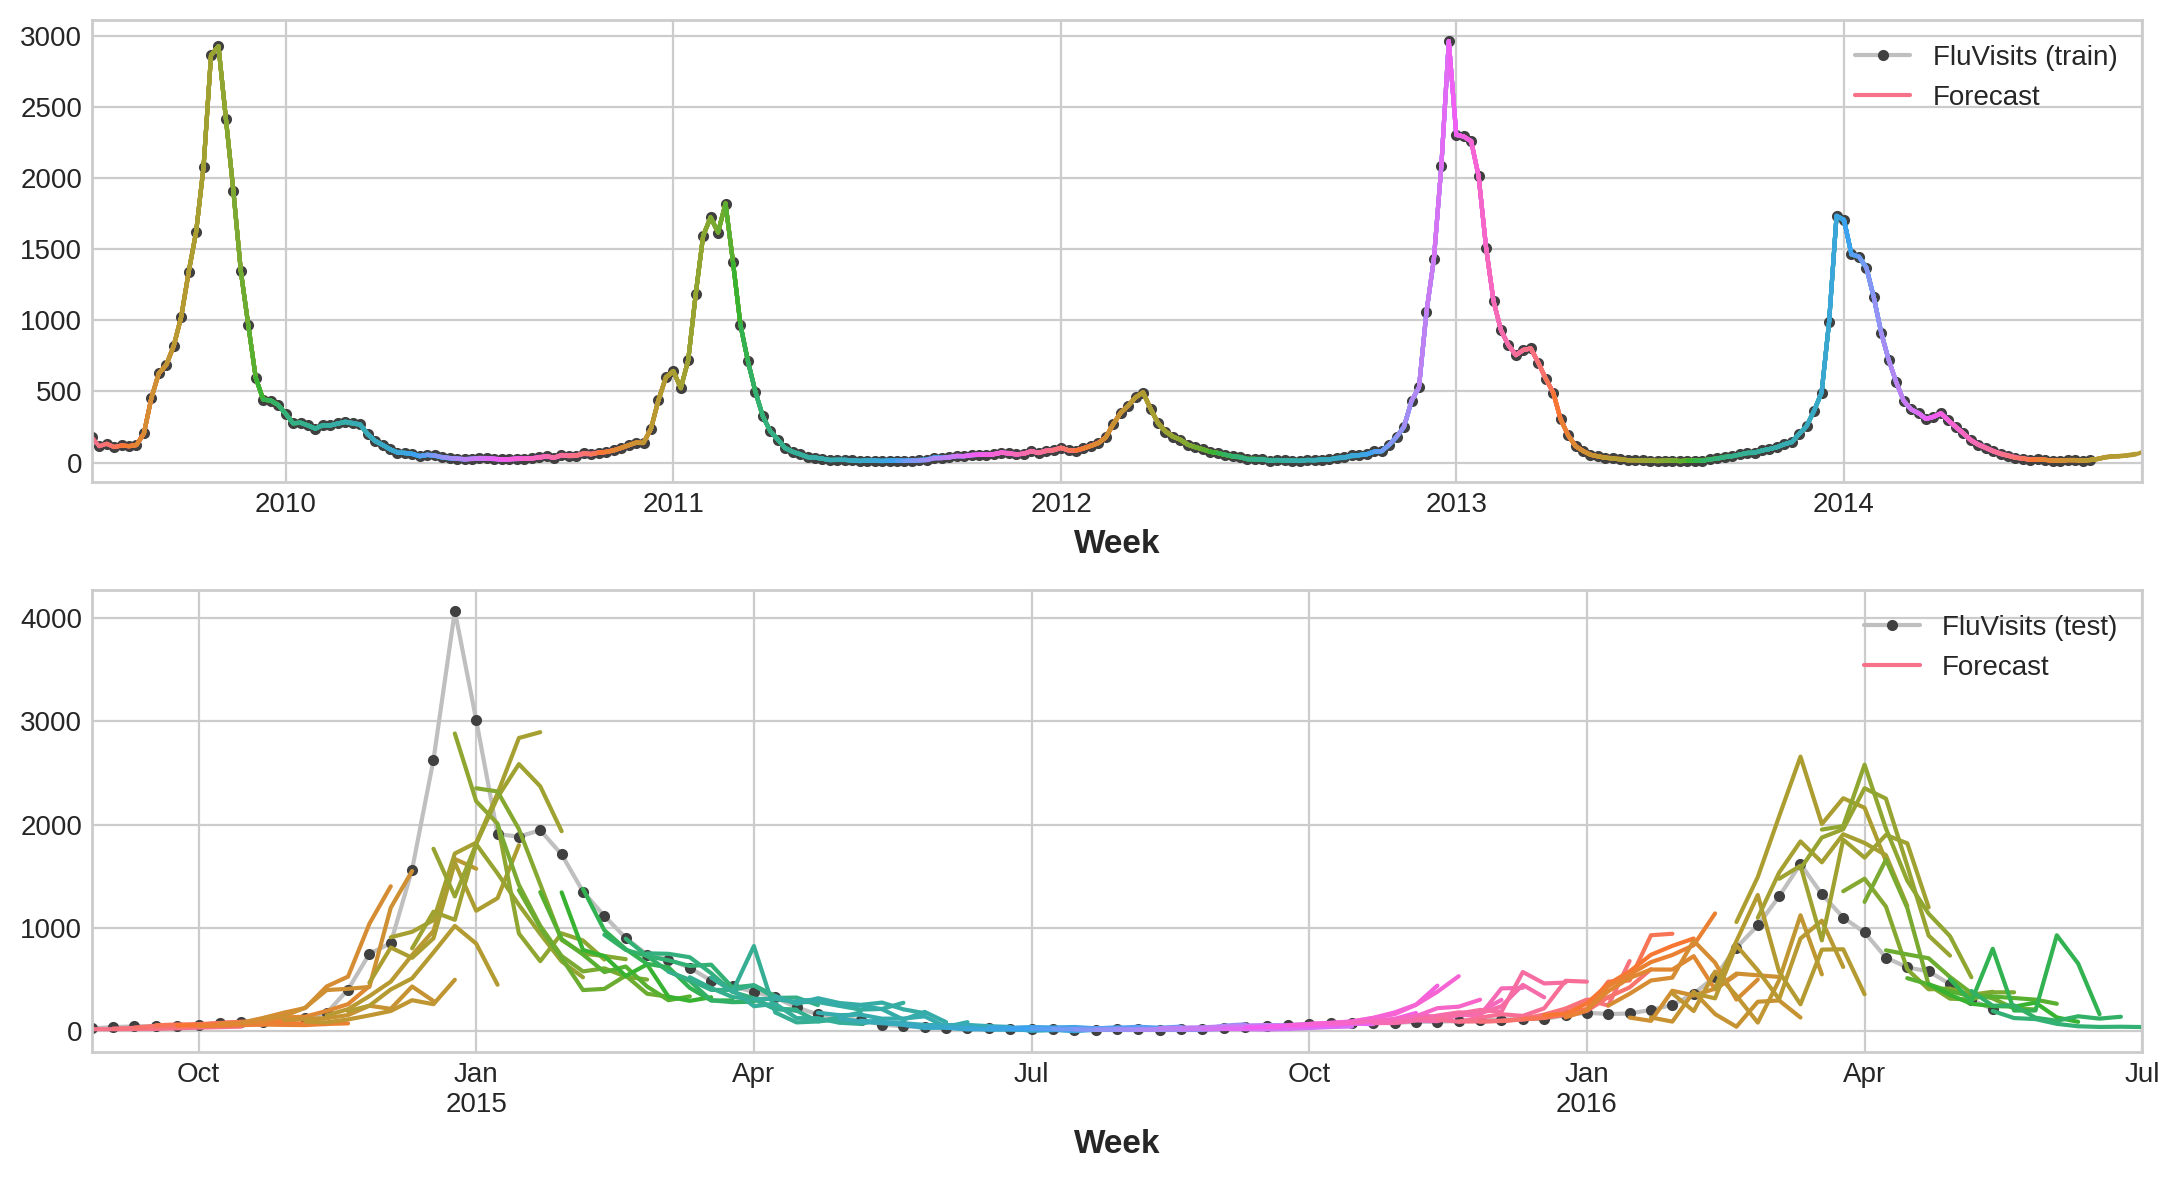

In [34]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### DirRec Strategy

To use the DirRec strategy, you would only need to replace MultiOutputRegressor with another scikit-learn wrapper, RegressorChain. The Recursive strategy we would need to code ourselves.



In [35]:
from sklearn.multioutput import RegressorChain

model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index = X_train.index, columns = y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index = X_test.index, columns = y.columns)

Train RMSE: 112.72
Test RMSE: 560.74


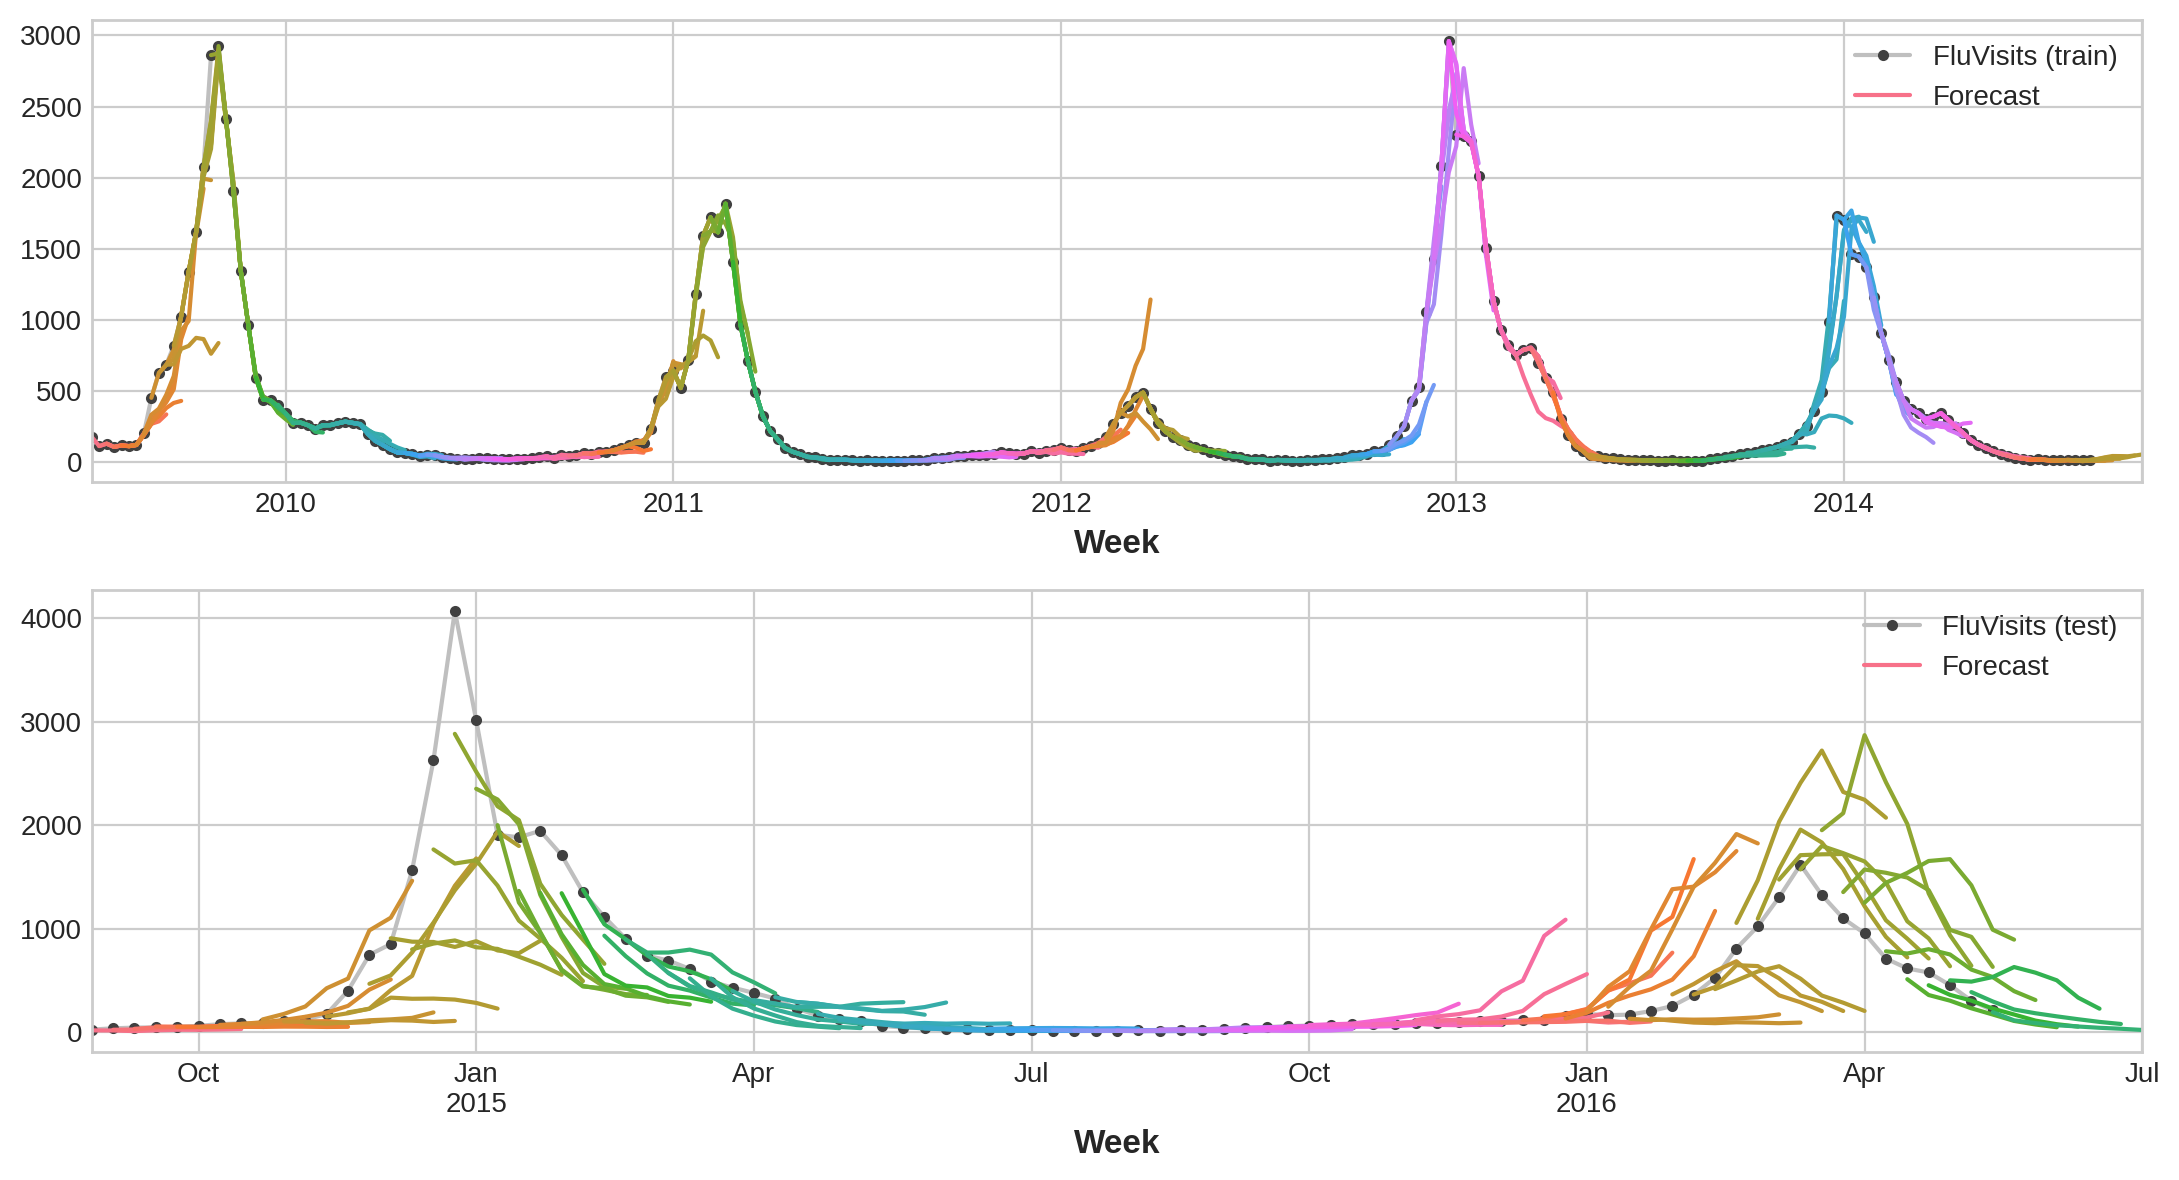

In [36]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])